### 1-1. 인물사진을 만들어보자

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(3024, 4032, 3)


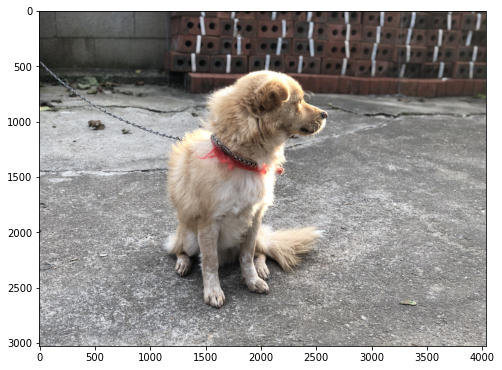

In [17]:
# load image
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'  
img_orig = cv2.imread(img_path, cv2.IMREAD_COLOR)

print(img_orig.shape)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
# load semantic segmentation model
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [19]:
# segmentation output
segvalues, output = model.segmentAsPascalvoc(img_path)

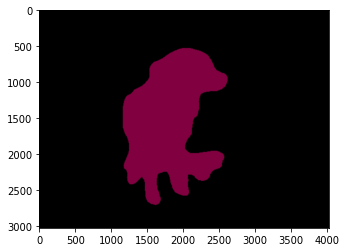

In [20]:
plt.imshow(output)
plt.show()

In [21]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [22]:
# colormap 출력
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20]) #생성한 20개의 컬러맵 출력

# 강아지에 해당하는 컬러맵 색상
colormap[12] # dog : [64, 0, 128]

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]


array([ 64,   0, 128])

In [23]:
# colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있으므로
# 색상순서를 변경한다
seg_color = (128, 0, 64)

(3024, 4032)


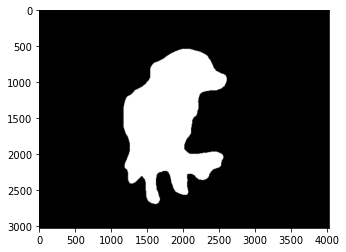

In [24]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

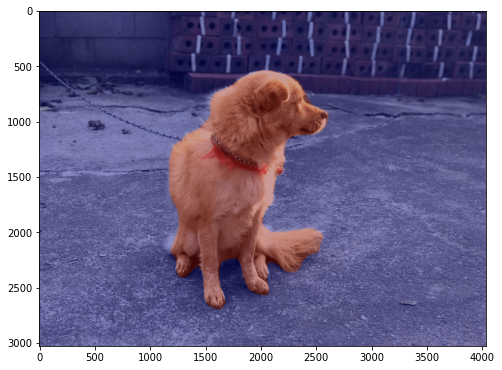

In [25]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

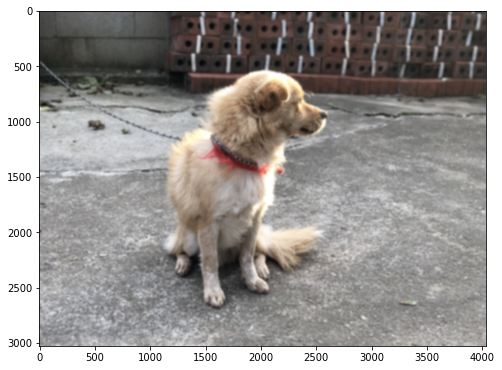

In [26]:
# blur background 이미지
img_orig_blur = cv2.blur(img_orig, (21, 21)) # (13,13) : blurring kernel size

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 강아지가 0인 경우에는 강아지가 있던 모든 픽셀이 0이 됩니다. 결국 강아지는 사라지고 배경만 남아요!

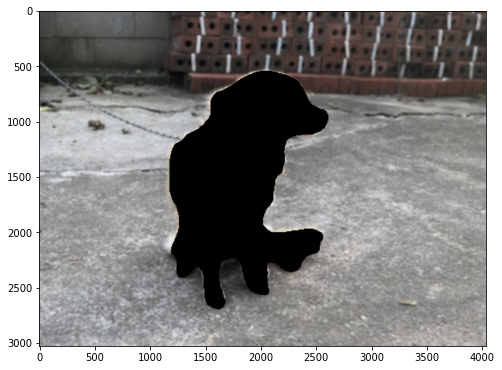

In [27]:
# blur 이미지에서 강아지 영역인 부분을 제거해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not() -> 이미지 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

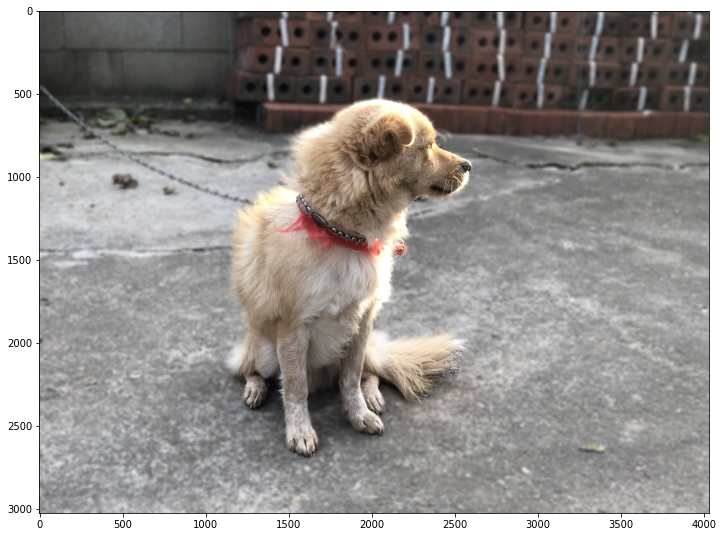

In [28]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # np.where(조건, 참일때, 거짓일때)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

위와 같은 프로세스를 셀카에도 적용해보았다  
![alt text](./results/selfie_result.png)

### 1-2. 크로마키 사진으로 바꾸기

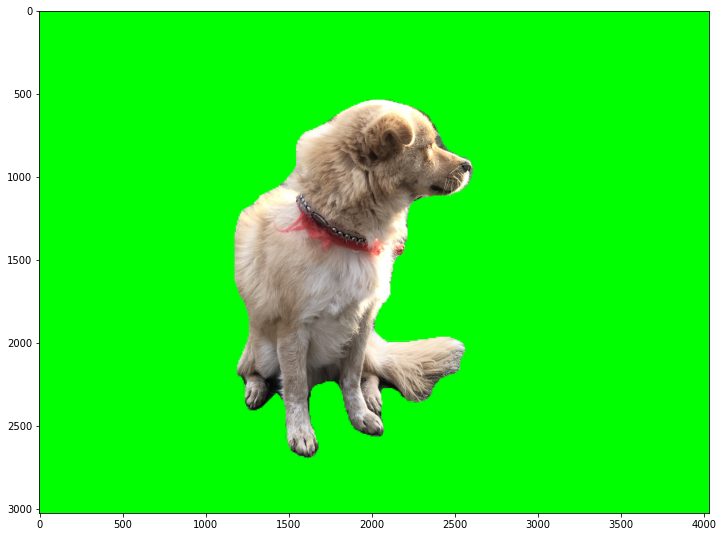

In [30]:
# 조건을 만족하지 않을 때(mask에 포함되지 않는 영역) 
img_concat = np.where(img_mask_color==255, img_orig, [0, 255, 0]).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 인물사진 모드의 문제점

![alt text](./results/hairshop_result.png)

&emsp;위의 사진은 같은 프로세스를 다른 인물사진에 동일하게 적용한 결과다. 스마트폰 부분을 주목해보자. 우리가 사용하는 스마트폰의 인물사진 모드를 적용했을 때, 포커싱이 되어 선명하게 나타나는 부분은 스마트폰과 쥐고 있는 손이 되어야 한다. 그런데 이 사진에서는 스마트폰이 아웃포커싱된 것처럼 나타나고 사람 부분이 선명하게 보인다. 왜 이런 문제가 생기는 걸까?

##### 인물에 대한 segmentation 결과 = 인물사진?

&emsp; 결론부터 말하자면, 사람을 기준으로 누끼따기하는 방식의 인물사진 생성방식은 전제부터가 틀렸다. **인물사진은 피사체를 강조하고 배경을 흐리게 하는 효과를 얻기 위함이 주 목적**이며, 피사체가 사람인지 유무에 관계없이 **가까이 있는 피사체에 우선적으로 적용**되어야 하기 때문이다. 그런데 우리가 지금까지 해온 방식은 피사체의 클래스를 manual하게 설정해서 그것을 기준으로 segmentation하는 방식으로 흐리게 할 영역을 정해주었다. 만약 직전 사진처럼 다른 물체가 더 가까이 있는 경우, 그 물체에 대해서 다시 segmentation을 해야 인물사진 모드의 목적에 부합하는 결과가 나올 것이다.  
&emsp; 하지만 이런 과정이 들어가는 순간 인물모드의 자동화는 실패한 셈이다. 가까이 있는 피사체를 일일이 정해주는 과정이 개입해야 하기 때문이다. **그렇다면 target이 되는 피사체 지정을 자동화할 방법이 우리가 고민해 볼 지점이다.**

### 3. 개선 방안

##### Mono Depth Estimation

&emsp; 인간이 3차원 세계를 인지할 수 있는 이유는 두 개의 눈을 가졌기 때문이다. 이를 모방하여 두 개 이상의 카메라를 통해 얻은 영상에서 한 physical space의 한 point에 대한 disparity를 구함으로써 depth를 추정하는 task가 stereo depth estimation이다. 반면 단일 카메라의 이미지로부터 깊이 정보를 추정하는 작업이 **mono depth estimation**이다.  

![alt text](./images/monodepth.png)

&emsp; 단일 카메라로 얻은 RGB 이미지(x)로부터, ground-truth(y_true)에 근접한 depth prediction을 얻는 것이 mono depth estimation의 목적이다.

##### 적용 방안은?


&emsp; Mono depth estimation으로 depth prediction을 얻으면 threshold를 기준으로 강조할 물체와 배경을 정할 수 있을 것이다. 예를 들면 파란색의 강도를 기준으로 threshold를 지정하면 파란색이 threshold 이상으로 나타나는 지 유무로 이미지를 이진화할 수 있을 것이다. 이렇게 이진화한 이미지를 그대로 마스크로 사용하면 segmentation 과정에서 클래스를 지정하지 않고도 자동으로 강조될 물체가 지정될 것이다.